<a href="https://colab.research.google.com/github/SharanyaVermaRaj/Record-Breakers/blob/main/ISP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files

# Upload the 12-bit raw image file
uploaded = files.upload()
# This will allow you to select the file and store it in Colab's environment


Saving 1920x1280x12bitsxGRBG_2850K_2000Lux.raw to 1920x1280x12bitsxGRBG_2850K_2000Lux.raw


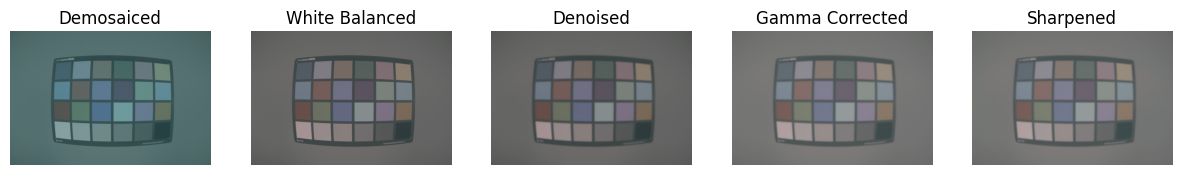

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
from skimage import exposure

# Parameters for the raw image
image_path = '1920x1280x12bitsxGRBG_2850K_2000Lux.raw'
width, height = 1920, 1280

# Load and normalize the 12-bit raw Bayer image
with open(image_path, 'rb') as f:
    raw_data = np.frombuffer(f.read(), dtype=np.uint16).reshape((height, width))

# Convert 12-bit Bayer data to 8-bit for consistent processing
raw_data_8bit = (raw_data / 4095.0 * 255).astype(np.uint8)

# Step 1: Demosaicing
def demosaic_edge_based(raw_image):
    rgb_image = cv2.cvtColor(raw_image, cv2.COLOR_BayerGR2BGR)
    return rgb_image

demosaiced_image = demosaic_edge_based(raw_data_8bit)

# Step 2: White balance with Gray World algorithm and constrained scaling
def white_balance(rgb_image):
    avg_rgb = np.mean(rgb_image, axis=(0, 1))
    avg_gray = np.mean(avg_rgb)
    scaling_factors = avg_gray / avg_rgb
    scaling_factors = np.clip(scaling_factors, 0.9, 2.1)  # Tighter clipping for color consistency

    balanced_image = rgb_image * scaling_factors
    return np.clip(balanced_image, 0, 255).astype(np.uint8)

white_balanced_image = white_balance(demosaiced_image)

# Step 3: Denoising with Gaussian filter
def denoise(rgb_image, sigma=1.0):
    return gaussian_filter(rgb_image, sigma=[sigma, sigma, 0])

denoised_image = denoise(white_balanced_image, sigma=5.0)

# Step 4: Gamma correction using sRGB gamma
def gamma_correction(rgb_image, gamma=1.2):
    rgb_image = rgb_image / 255.0  # Normalize to [0,1]
    corrected = exposure.adjust_gamma(rgb_image, 1/gamma) * 255
    return np.clip(corrected, 0, 255).astype(np.uint8)

gamma_corrected_image = gamma_correction(denoised_image)

# Step 5: Sharpening with Unsharp Mask in LAB color space
def sharpen_in_lab(rgb_image, radius=1.0, amount=0.5):
    # Convert to LAB color space to apply sharpening only on the L (lightness) channel
    lab_image = cv2.cvtColor(rgb_image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab_image)

    # Apply unsharp mask on the lightness channel
    blurred_l = gaussian_filter(l, sigma=radius)
    sharpened_l = l + amount * (l - blurred_l)
    sharpened_l = np.clip(sharpened_l, 0, 255).astype(np.uint8)

    # Merge channels back and convert to BGR color space
    sharpened_lab = cv2.merge((sharpened_l, a, b))
    sharpened_image = cv2.cvtColor(sharpened_lab, cv2.COLOR_LAB2BGR)
    return sharpened_image

sharpened_image = sharpen_in_lab(gamma_corrected_image, radius=1.0, amount=0.5)

# Display results at each step to check colors
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
titles = ['Demosaiced', 'White Balanced', 'Denoised', 'Gamma Corrected', 'Sharpened']
images = [demosaiced_image, white_balanced_image, denoised_image, gamma_corrected_image, sharpened_image]

for ax, img, title in zip(axes, images, titles):
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(title)
    ax.axis('off')

plt.show()


Raw Data - Min: 565 Max: 2675 Shape: (1280, 1920)


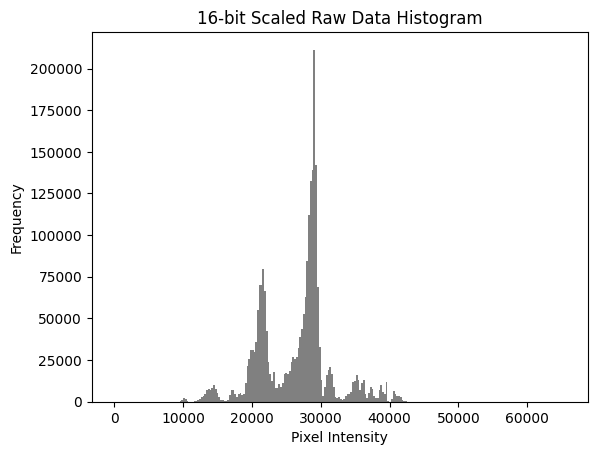

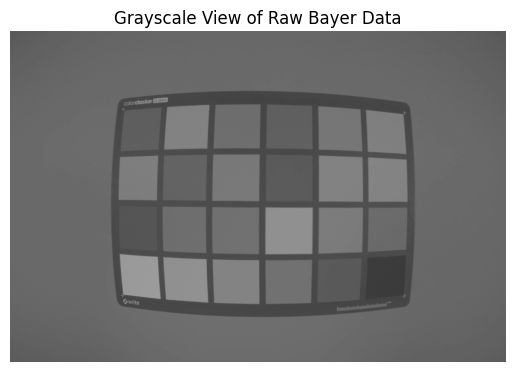

Testing pattern: COLOR_BayerGR2BGR


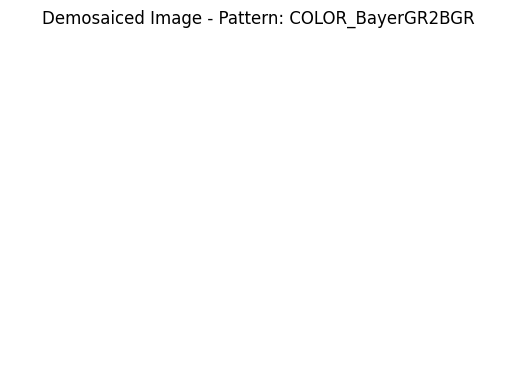

Testing pattern: COLOR_BayerBG2BGR


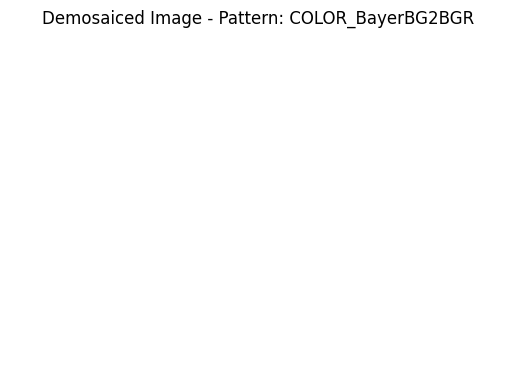

Testing pattern: COLOR_BayerRG2BGR


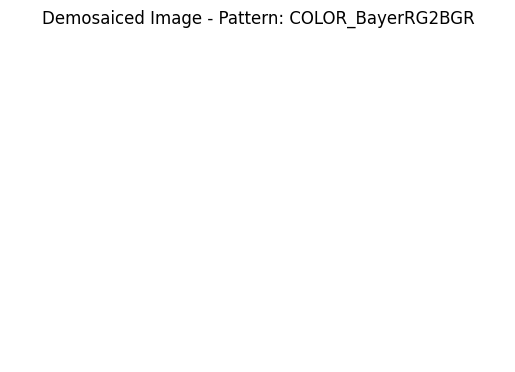

Testing pattern: COLOR_BayerGB2BGR


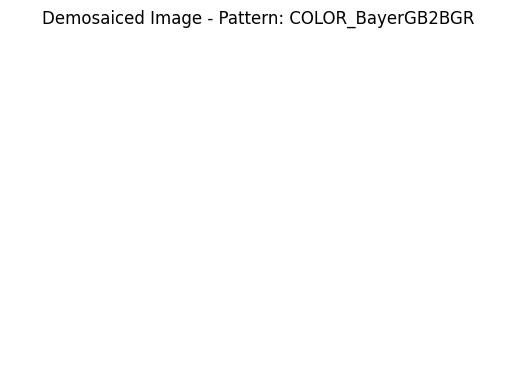

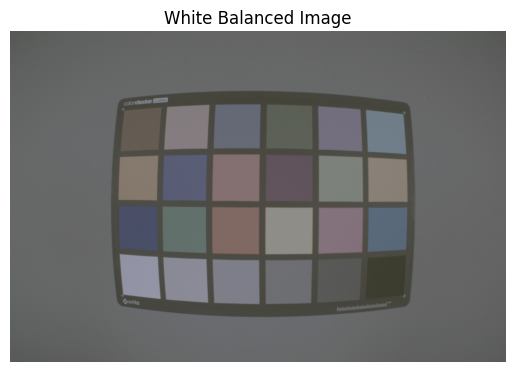

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Parameters for the raw image
image_path = '1920x1280x12bitsxGRBG_2850K_2000Lux.raw'
width, height = 1920, 1280

# Step 1: Load the 12-bit raw Bayer image
with open(image_path, 'rb') as f:
    raw_data = np.frombuffer(f.read(), dtype=np.uint16).reshape((height, width))

# Debugging: Check basic statistics of raw data
print("Raw Data - Min:", raw_data.min(), "Max:", raw_data.max(), "Shape:", raw_data.shape)

# Step 2: Scale from 12-bit to 16-bit
raw_data_16bit = (raw_data / 4095.0 * 65535).astype(np.uint16)

# Optional: Show histogram of raw data
plt.hist(raw_data_16bit.ravel(), bins=256, range=(0, 65535), color='gray')
plt.title("16-bit Scaled Raw Data Histogram")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.show()

# Step 3: Display Raw Bayer data as-is (for inspection)
# Converting the Bayer data to a visible grayscale image
plt.imshow(raw_data_16bit, cmap='gray', vmin=0, vmax=65535)
plt.title("Grayscale View of Raw Bayer Data")
plt.axis('off')
plt.show()

# Step 4: Attempt Demosaicing
# Test with multiple Bayer patterns to find the correct one
def demosaic_edge_based(raw_image, bayer_pattern='COLOR_BayerGR2BGR'):
    try:
        rgb_image = cv2.cvtColor(raw_image, getattr(cv2, bayer_pattern))
        return rgb_image
    except Exception as e:
        print(f"Error during demosaicing: {e}")
        return None

# Test various Bayer patterns to find the correct one
patterns = ['COLOR_BayerGR2BGR', 'COLOR_BayerBG2BGR', 'COLOR_BayerRG2BGR', 'COLOR_BayerGB2BGR']
for pattern in patterns:
    print(f"Testing pattern: {pattern}")
    demosaiced_image = demosaic_edge_based(raw_data_16bit, pattern)

    if demosaiced_image is not None:
        plt.imshow(cv2.cvtColor(demosaiced_image, cv2.COLOR_BGR2RGB))
        plt.title(f"Demosaiced Image - Pattern: {pattern}")
        plt.axis('off')
        plt.show()

# Step 5: Debug and Visualize Each Stage Separately

# Test White Balance (using an initial test on demosaiced image)
def white_balance(rgb_image):
    avg_rgb = np.mean(rgb_image, axis=(0, 1))
    avg_gray = np.mean(avg_rgb)
    scaling_factors = avg_gray / avg_rgb
    balanced_image = rgb_image * scaling_factors
    balanced_image = np.clip(balanced_image, 0, 65535)  # for 16-bit range
    return balanced_image.astype(np.uint16)

# Apply white balance if demosaiced_image is valid
if demosaiced_image is not None:
    balanced_image = white_balance(demosaiced_image)
    plt.imshow(cv2.cvtColor((balanced_image / 256).astype(np.uint8), cv2.COLOR_BGR2RGB))
    plt.title("White Balanced Image")
    plt.axis('off')
    plt.show()
else:
    print("Demosaiced image is None. Check Bayer pattern.")



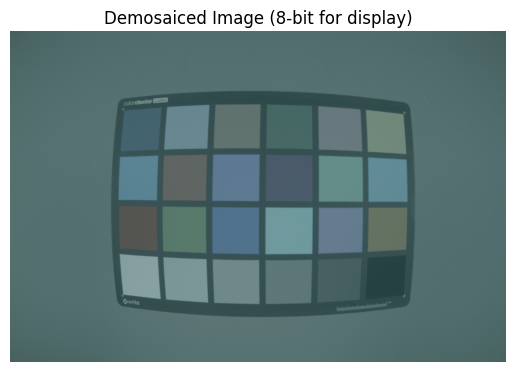

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Parameters for the raw image
image_path = '1920x1280x12bitsxGRBG_2850K_2000Lux.raw'
width, height = 1920, 1280

# Step 1: Load the 12-bit raw Bayer image
with open(image_path, 'rb') as f:
    raw_data = np.frombuffer(f.read(), dtype=np.uint16).reshape((height, width))

# Scale to 16-bit for processing but for display, we'll convert to 8-bit
raw_data_16bit = (raw_data / 4095.0 * 65535).astype(np.uint16)

# Step 2: Demosaicing (convert to RGB)
def demosaic_edge_based(raw_image):
    rgb_image = cv2.cvtColor(raw_image, cv2.COLOR_BayerGR2BGR)
    return rgb_image

demosaiced_image = demosaic_edge_based(raw_data_16bit)

# Convert to 8-bit for display
demosaiced_image_8bit = (demosaiced_image / 256).astype(np.uint8)

# Step 3: Displaying with Matplotlib
plt.imshow(cv2.cvtColor(demosaiced_image_8bit, cv2.COLOR_BGR2RGB))
plt.title("Demosaiced Image (8-bit for display)")
plt.axis('off')
plt.show()
